# Imports

In [1]:
#General
import os as os
from os.path import join
from google.colab import drive
from PIL import Image
!pip install cairosvg
import cairosvg
import glob
import cv2
from google.colab.patches import cv2_imshow
import shutil
import warnings
from types import SimpleNamespace
from tqdm import tqdm
import math
from mpl_toolkits.axes_grid1 import ImageGrid

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# PyTorch components
import torchvision
from torchvision import datasets
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torch.optim as optim

warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.5 MB/s eta 0:00:00


# Dataset initialization

## Creating the .png from .svg files

Let's convert the .svg files to .png

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets/"

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    name = image.split(sep=".")[0]
    # Convert SVG to PNG
    try:
      cairosvg.svg2png(url=os.path.join(specific_folder,image), write_to=os.path.join(specific_folder,name+'.png'))
    except Exception as e:
      print(e)

Mounted at /content/gdrive
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0
syntax error: line 1, column 0


Then i need to delete the .svg files since i will not need them anymore

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"
#specific pattern to eliminate
file_pattern = '*.svg'

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  full_pattern = os.path.join(specific_folder, file_pattern)
  for svg in glob.glob(full_pattern):
    try:
        os.remove(svg)  # Delete the file
    except Exception as e:
        print(f"Error deleting {full_pattern}: {e}")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


The next thing to do is to take a look inside the folders in order to check if some of the pieces are too weirdly shaped to be part of a training/testing set.

## Pieces shape check and removal

In the following i wrote the folder names that need to be evaluated before moving on with the project.

In [ ]:
to_remove = ["anarcandy",    #too weirdly shaped
             "disguised",   #too weirdly shaped
             "horsey",      #too weirdly shaped
             "kiwen-suwi",   #too weirdly shaped, knights are the other way around
             "letter",      #too weirdly shaped
             "mono",        #monochromatic
             "reillycraig", #too small
             "shapes"]      #too weirdly shaped

maybe_remove = ["dubrovny",     #pieces have different color
                "caliente",     #too small
                "fantasy",      #too weirdly shaped
                "leipzig",      #too weirdly shaped
                "monarchy",     #too weirdly shaped
                "piruetti",     #no edges around images
                "pixel",        #too small, too weirdly shaped
                "spatial"]      #too weirdly shaped

Let's take a better look at the to_remove and maybe remove piece sets.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Folder:anarcandy


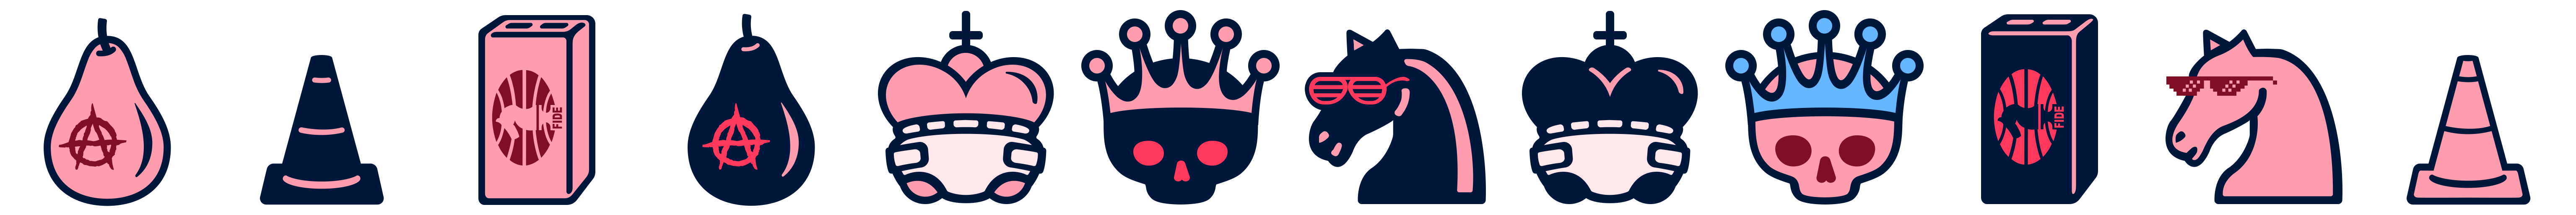


Folder:disguised


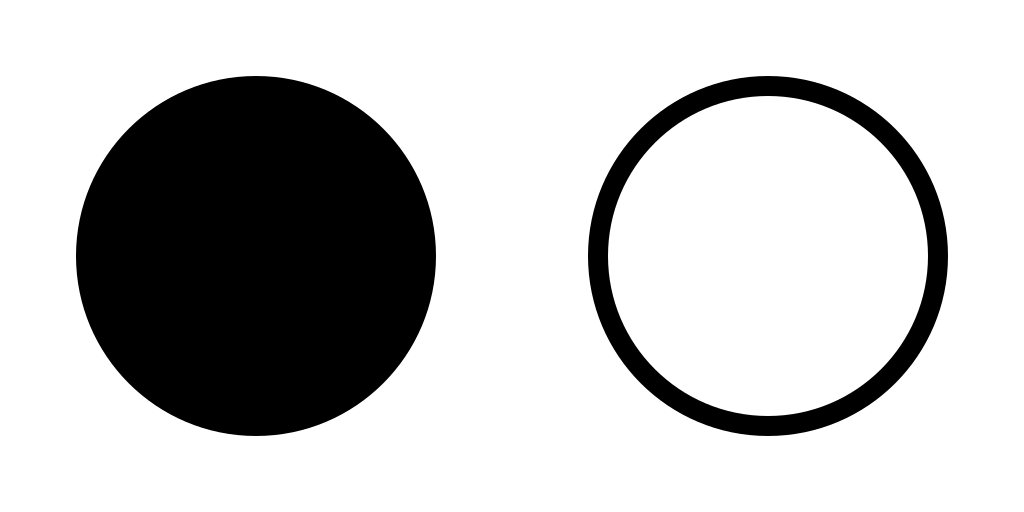


Folder:kiwen-suwi


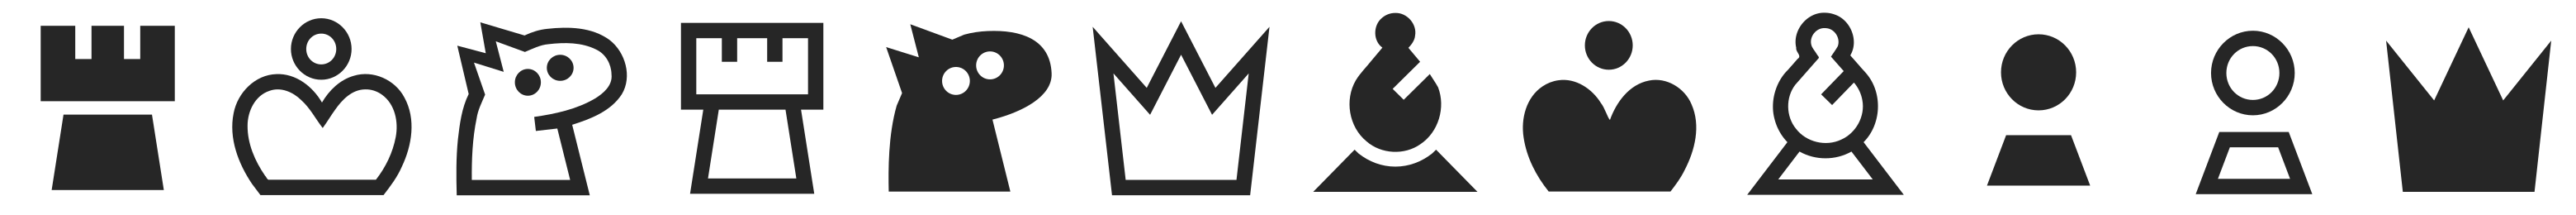


Folder:horsey


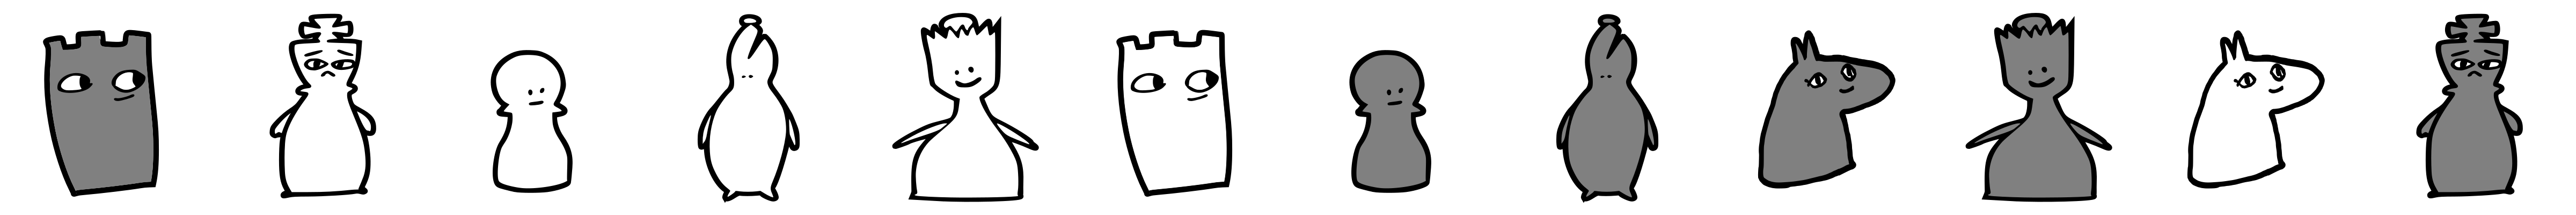


Folder:letter


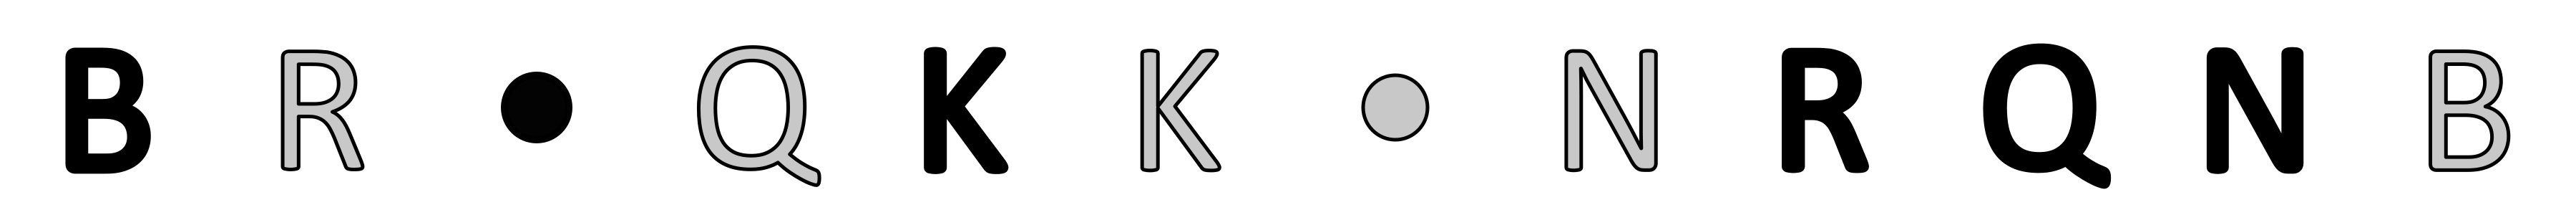


Folder:mono


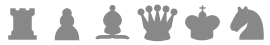


Folder:reillycraig



Folder:shapes


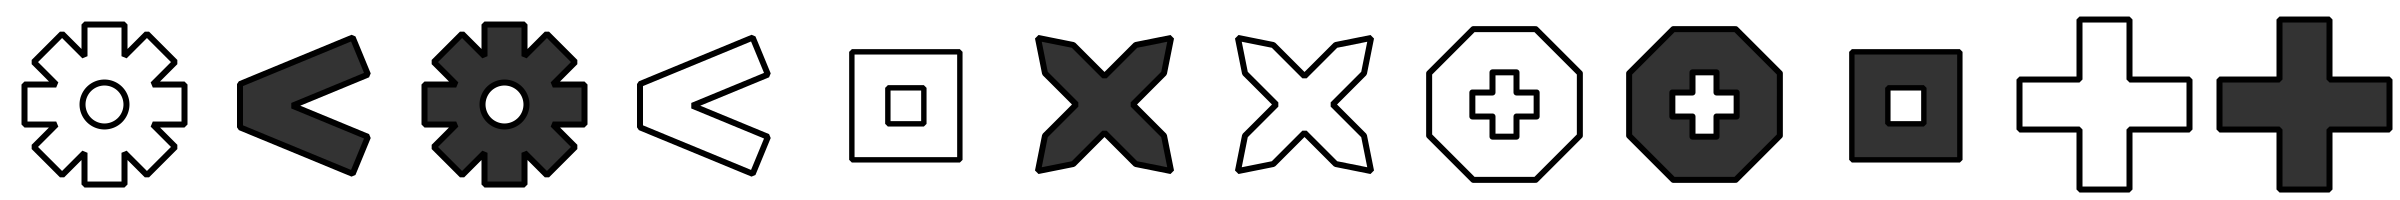

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"

remove = []

for folder in os.listdir(path):
  if folder in to_remove:
    specific_folder = os.path.join(path, folder)
    print(f"Folder:{folder}")
    for image in os.listdir(specific_folder):
      img = cv2.imread(os.path.join(specific_folder, image), cv2.IMREAD_UNCHANGED)
      remove.append(img)

    cv2_imshow(cv2.hconcat(remove))
    remove = []
    print()


In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"

remove = []

for folder in os.listdir(path):
  if folder in maybe_remove:
    specific_folder = os.path.join(path, folder)
    print(f"Folder:{folder}")
    for image in os.listdir(specific_folder):
      img = cv2.imread(os.path.join(specific_folder, image), cv2.IMREAD_UNCHANGED)
      remove.append(img)

    cv2_imshow(cv2.hconcat(remove))
    remove = []
    print()

Output hidden; open in https://colab.research.google.com to view.

Let's eliminate the to_remove folders before stepping into the next part of the project.

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"

for folder in os.listdir(path):
  if folder in to_remove:
    specific_folder = os.path.join(path, folder)
    shutil.rmtree(specific_folder)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Applying backgrounds to the pgns

I need to set different background colors for each of my .pgn in order to emulate the possible different Lichess boards and expose the model to not just the pieces shapes. I will need to create a lighter version, as well as a darker one, just like on the board.

In [ ]:
color_scheme = [(218, 166, 113), #light brown
                (146, 116, 84),  #dark brown
                (214, 245, 255), #light cyan
                (153, 210, 229), #dark cyan
                (194, 255, 194), #light green
                (155, 217, 155), #dark green
                (222, 222, 222), #light grey
                (148, 148, 148), #dark grey
                (186, 156, 196), #light purple
                (164, 108, 183)  #dark purple
                ]

In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Lichess_Piece_Sets"
cont = 0

try:
  #grouped pieces folder
  os.mkdir(f'{path}/Grouped_Pieces/')
  #pieces folders
  os.mkdir(f'{path}/Grouped_Pieces/0.Pawns')
  os.mkdir(f'{path}/Grouped_Pieces/1.Knights/')
  os.mkdir(f'{path}/Grouped_Pieces/2.Bishops/')
  os.mkdir(f'{path}/Grouped_Pieces/3.Rooks/')
  os.mkdir(f'{path}/Grouped_Pieces/4.Queens/')
  os.mkdir(f'{path}/Grouped_Pieces//5.Kings/')
except FileExistsError:
    print("Grouped folders already exist!")

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    # Open the existing PNG image
    im = Image.open(os.path.join(specific_folder,image))
    # Define the new background color (RGB format)
    for color in color_scheme:
      new_im = im.convert("RGBA")
      # Create a new image with the same size and the desired background color in RGB mode
      background = Image.new("RGB", im.size, color)
      # Paste the original image on top of the background, using its alpha channel as a mask
      background.paste(im, (0, 0), new_im)
      name = image.split(sep=".")[0]
      match name:
        case "bP" | "wP":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/0.Pawns/{name}{cont}.png")
        case "bN" | "wN":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/1.Knights/{name}{cont}.png")
        case "bB" | "wB":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/2.Bishops/{name}{cont}.png")
        case "bR" | "wR":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/3.Rooks/{name}{cont}.png")
        case "bQ" | "wQ":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/4.Queens/{name}{cont}.png")
        case "bK" | "wK":
          background.save(f"/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/5.Kings/{name}{cont}.png")
      cont += 1

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Checking the images dimensions distribution

In [ ]:
pieces = pd.DataFrame(columns=["Piece","Path","Dimension"])

drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/"

for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    name = image.split(sep=".")[0]
    img = Image.open(os.path.join(specific_folder,image))
    width, height = img.size
    dimension = str(width) + "x" + str(height)

    if "P" in name: name = "Pawn"
    elif "N" in name: name = "Knight"
    elif "B" in name: name = "Bishop"
    elif "R" in name: name = "Rook"
    elif "Q" in name: name = "Queen"
    elif "K" in name: name = "King"

    pieces.loc[len(pieces)] = [name,os.path.join(specific_folder,image),dimension] #adding elements at the end of my DataFrame

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pieces["Piece"] = pieces['Piece'].astype(str)
pieces["Path"] = pieces['Path'].astype(str)
pieces["Dimension"] = pieces['Dimension'].astype(str)

<Axes: >

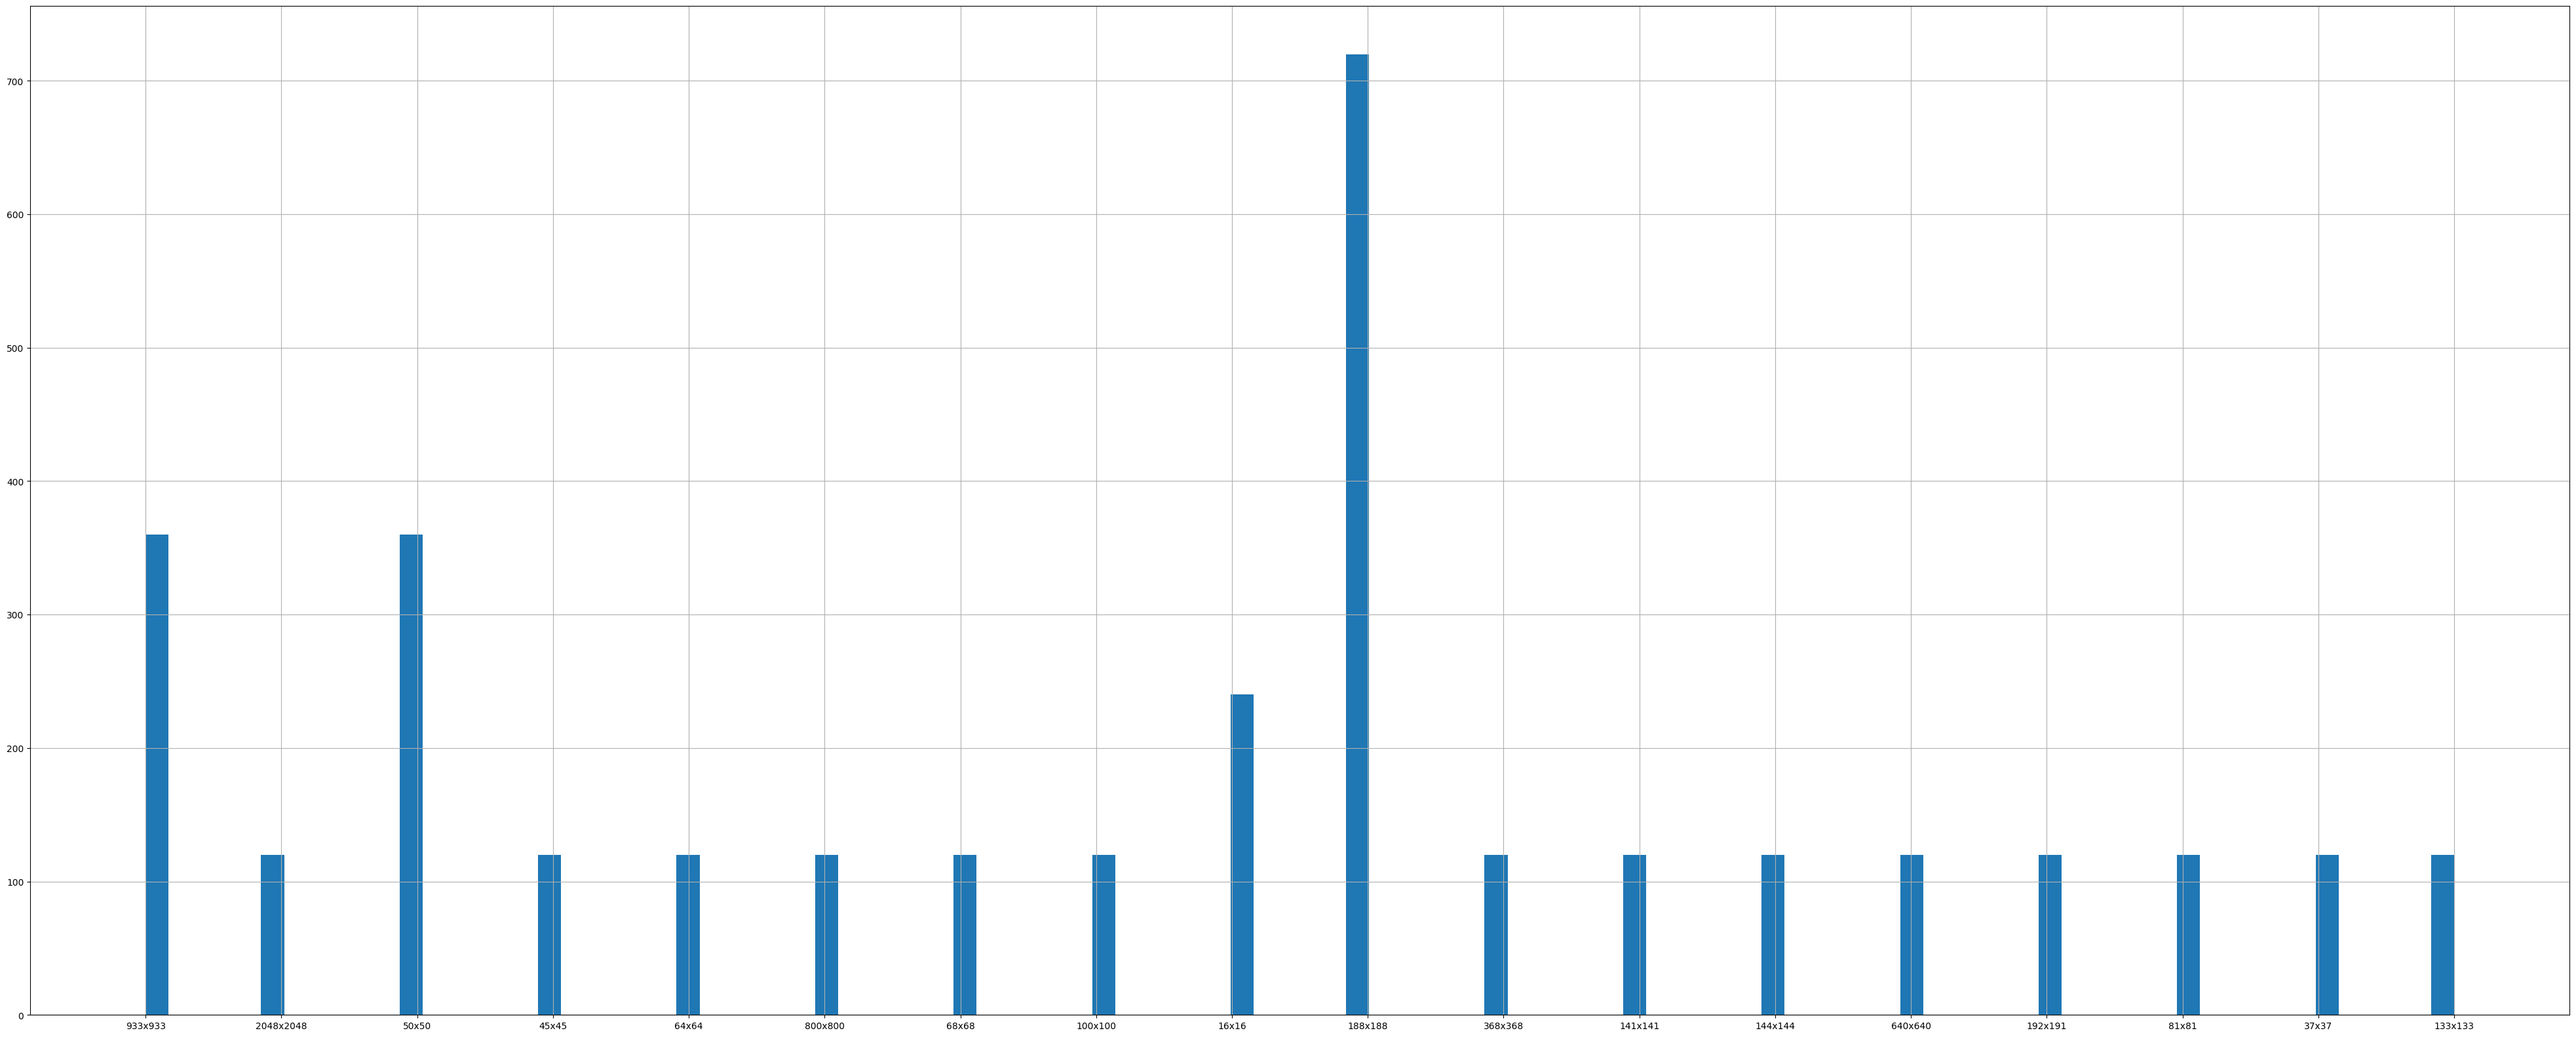

In [ ]:
#pieces["Dimension"].loc[(pieces["Piece"] == "Pawn")].hist(figsize=(50,20), bins=50)
pieces["Dimension"].hist(figsize=(50,20), bins=100)

As we can see we have a wide dimensionality range.

CNN works by training and testing on images that have the same dimensionality so we need to make some adjustments.

I need to scale all the images to have the same dimensionality, and then delete the ones the are too raw to be useful.

I run a test by screenshotting some chess positions from youtube, lichess and chess.com and the resulting resolutions are:
- lichess.org: 704x711
- chess.com: 868x876
- youtube fullscreen: 1062x1060
- youtube ***not*** fullscreen: 681x697

From which we get, more or less depending on the quality of the screenshot taken, the following ***single cell resolutions***:
- lichess.org: 88x88
- chess.com: 110x110
- youtube fullscreen: 132x130
- youtube ***not*** fullscreen: 82x86

Given these informations i think that **100x100** (close to the mean value) should be the best dimensionality to scale ***each training and test image***.
The entire chessboard screenshot should then be scales to **800x800**.

## Dataset cleaning and visualization

Let's start by deleting all the images with dimension 1x1

In [ ]:
# print("Pieces with dimension 1x1: " + str(pieces["Path"].loc[pieces["Dimension"] == "1x1"].sum()))

# for path in pieces["Path"].loc[pieces["Dimension"] == "1x1"]:
#   os.remove(path)
#   pieces.drop(pieces[pieces['Path'] == path].index, inplace=True)

# print("[CHECK AFTER DELETE] Pieces with dimension 1x1 remaining: " + str(pieces["Path"].loc[pieces["Dimension"] == "1x1"].sum()))

Let's run a test and see the resulting images after resing them to 100x100.

In [ ]:
new_images = []
cont = 0

for path in pieces["Path"]:
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  new_dimensions = (100,100)
  resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_AREA)
  new_images.append(resized_img)
  if cont >= 17:
    cv2_imshow(cv2.hconcat(new_images))
    new_images = []
    cont = 0
  else:
    cont += 1

Output hidden; open in https://colab.research.google.com to view.

The results seem pretty good even for the low quality pieces, therefore i am going to keep them in order to expose the model i'm training to some low quality ones.

## Changing the pieces dimensionality related to the test size

The main idea is that i need to have a screenshot whose single cell dimensionality matches the dimensionality of the pieces i trained on. Therefore i need to make the pieces all the same dimension, then multiply each of their dimension by 8. **This result will be the dimensionality i need to set my screenshot to**, so that by diving it into 64 squared, each and every one will match the pieces size i trained on. As said before, i would like to set the dimensionality of each piece to be **100x100**.

1. random piece width = x, random piece height = y
2. scaled piece width = x' -> 100, scaled piece height = y' -> 100
3. scaled screenshot width = x' * 8, scaled screenshot height = y' * 8
4. scaled single cell screenshot width = x' -> 100, scaled single cell screenshot height = y' -> 100

In [ ]:
#rescale each image to have dimensionality 100x100
for path in pieces["Path"]:
  img = cv2.imread(path)
  new_dimensions = (100,100)
  resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_AREA) #this type of interpolation tries to keep the quality when upscaling/downscaling
  filename = path.split("/")[-1] #just take the {name}.pgn
  cv2.imwrite(path, resized_img) #overwrite the existing images with the resized ones

# From images to tensors

The dataset must be organized in this way in order to use DataLoader by pytoch:

```
dataset/
    train/
        class_1/
            img1.jpg
            img2.jpg
        class_2/
            img1.jpg
            img2.jpg
    test/
        class_1/
            img1.jpg
        class_2/
            img1.jpg
```

## Train/Validation/Test classes creation

I want to create a DataFrame containing each of my piece and its path. I will then apply *train_test_split* from scikit learn to randomly permute it and split it into train and test. The creation of the folders and insertion of each piece inside the correct one will then be straighforward.

In [2]:
#DataFrame creation

drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Grouped_Pieces/"


dataset = pd.DataFrame(columns=["Piece","Path"])
for folder in os.listdir(path):
  specific_folder = os.path.join(path, folder)
  for image in os.listdir(specific_folder):
    name = image.split(sep=".")[0][0:2] #i take into account just the first 2 letters (color + piece)
    match name:
      case "wP":
        dataset.loc[len(dataset)] = ["WhitePawn",str(os.path.join(specific_folder, image))]
      case "bP":
        dataset.loc[len(dataset)] = ["BlackPawn",str(os.path.join(specific_folder, image))]
      case "wN":
        dataset.loc[len(dataset)] = ["WhiteKnight",str(os.path.join(specific_folder, image))]
      case "bN":
        dataset.loc[len(dataset)] = ["BlackKnight",str(os.path.join(specific_folder, image))]
      case "wB":
        dataset.loc[len(dataset)] = ["WhiteBishop",str(os.path.join(specific_folder, image))]
      case "bB":
        dataset.loc[len(dataset)] = ["BlackBishop",str(os.path.join(specific_folder, image))]
      case "wR":
        dataset.loc[len(dataset)] = ["WhiteRook",str(os.path.join(specific_folder, image))]
      case "bR":
        dataset.loc[len(dataset)] = ["BlackRook",str(os.path.join(specific_folder, image))]
      case "wQ":
        dataset.loc[len(dataset)] = ["WhiteQueen",str(os.path.join(specific_folder, image))]
      case "bQ":
        dataset.loc[len(dataset)] = ["BlackQueen",str(os.path.join(specific_folder, image))]
      case "wK":
        dataset.loc[len(dataset)] = ["WhiteKing",str(os.path.join(specific_folder, image))]
      case "bK":
        dataset.loc[len(dataset)] = ["BlackKing",str(os.path.join(specific_folder, image))]

#70% train, (30% test -> 15% test, 15% validation)
train_dataset,test_dataset = train_test_split(dataset, test_size=.3, random_state=50) #the validation set will be created later on

Mounted at /content/gdrive


Let's take a look at the train and test pieces distributions before creating the folders. I would like to have a train instances distribution that is as close as possible to a uniform distribution.

Text(0.5, 1.0, 'Train pieces distribution (2352 pieces)')

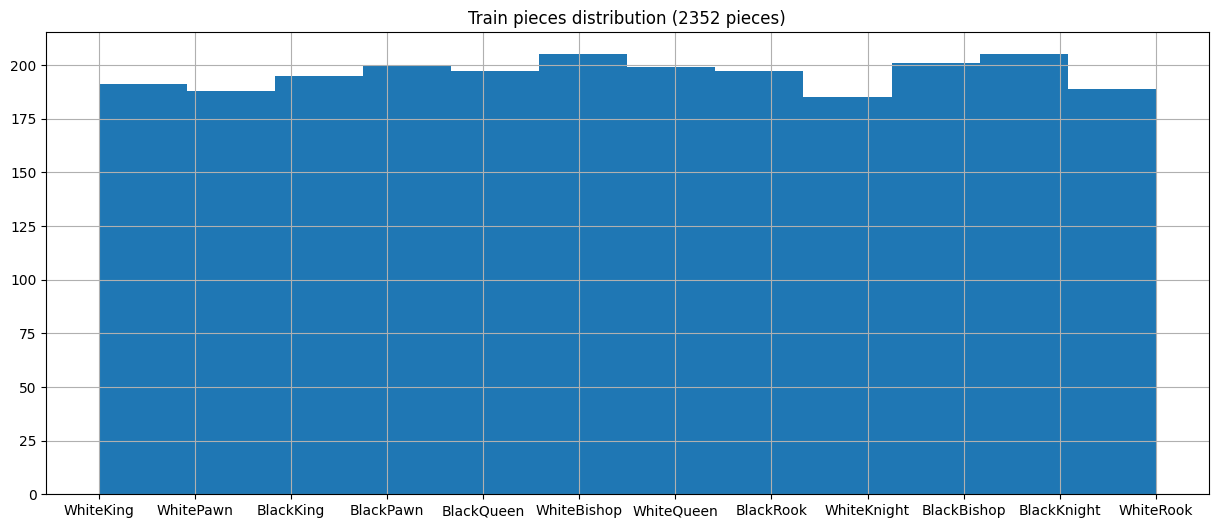

In [3]:
train_dataset["Piece"].hist(figsize=(15,6),bins=12).set_title(f"Train pieces distribution ({len(train_dataset)} pieces)")

Text(0.5, 1.0, 'Test pieces distribution (1008 pieces)')

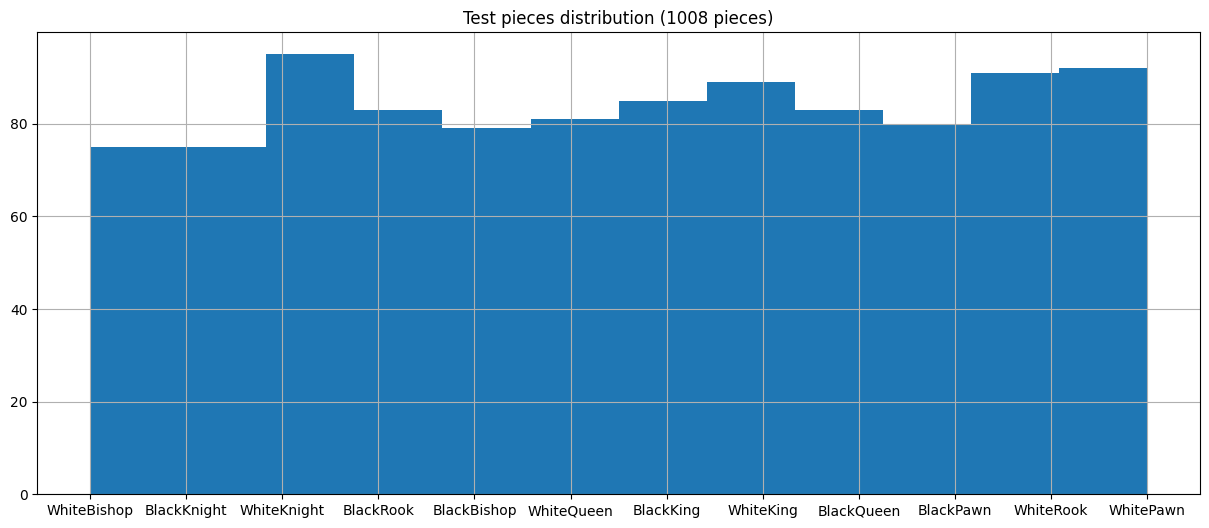

In [4]:
test_dataset["Piece"].hist(figsize=(15,6),bins=12).set_title(f"Test pieces distribution ({len(test_dataset)} pieces)")

## Default DataLoader path creation and folder population

In [ ]:
#Folders creation

drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN"

try:
  #dataset folder
  os.mkdir(f'{path}/dataset/')
  #train folder
  os.mkdir(f'{path}/dataset/train')
  #train classes
  os.mkdir(f'{path}/dataset/train/0wP')
  os.mkdir(f'{path}/dataset/train/1bP')
  os.mkdir(f'{path}/dataset/train/2wN')
  os.mkdir(f'{path}/dataset/train/3bN')
  os.mkdir(f'{path}/dataset/train/4wB')
  os.mkdir(f'{path}/dataset/train/5bB')
  os.mkdir(f'{path}/dataset/train/6wR')
  os.mkdir(f'{path}/dataset/train/7bR')
  os.mkdir(f'{path}/dataset/train/8wQ')
  os.mkdir(f'{path}/dataset/train/9bQ')
  os.mkdir(f'{path}/dataset/train/10wK')
  os.mkdir(f'{path}/dataset/train/11bK')
except FileExistsError:
    print("Train folders already exist!")

try:
  #test folder
  os.mkdir(f'{path}/dataset/test')
  #test classes
  os.mkdir(f'{path}/dataset/test/0wP')
  os.mkdir(f'{path}/dataset/test/1bP')
  os.mkdir(f'{path}/dataset/test/2wN')
  os.mkdir(f'{path}/dataset/test/3bN')
  os.mkdir(f'{path}/dataset/test/4wB')
  os.mkdir(f'{path}/dataset/test/5bB')
  os.mkdir(f'{path}/dataset/test/6wR')
  os.mkdir(f'{path}/dataset/test/7bR')
  os.mkdir(f'{path}/dataset/test/8wQ')
  os.mkdir(f'{path}/dataset/test/9bQ')
  os.mkdir(f'{path}/dataset/test/10wK')
  os.mkdir(f'{path}/dataset/test/11bK')
except FileExistsError:
  print("Test folders already exist!")

Mounted at /content/gdrive


In [ ]:
#from piece name to correct dataset train/test folder
def get_folder(piece):
    match str(piece):
      case "WhitePawn":
        return "0wP"
      case "BlackPawn":
        return "1bP"
      case "WhiteKnight":
        return "2wN"
      case "BlackKnight":
        return "3bN"
      case "WhiteBishop":
        return "4wB"
      case "BlackBishop":
        return "5bB"
      case "WhiteRook":
        return "6wR"
      case "BlackRook":
        return "7bR"
      case "WhiteQueen":
        return "8wQ"
      case "BlackQueen":
        return "9bQ"
      case "WhiteKing":
        return "10wK"
      case "BlackKing":
        return "11bK"

In [ ]:
train_destination_folder = "/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/dataset/train/"
test_destination_folder = "/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/dataset/test/"

count = 0
mean_acc = np.zeros(3)
std_acc = np.zeros(3)

#Populating the folders
for _,row in train_dataset.iterrows():
  img = cv2.imread(row["Path"])
  count += 1
  mean_acc += np.mean(img, axis=(0, 1))
  std_acc += np.std(img, axis=(0, 1))
  filename = os.path.join((os.path.join(train_destination_folder, str(get_folder(row["Piece"])))), row["Path"].split("/")[-1]) #filename = train_destination_folder/*correct_class_folder*/image.png
  cv2.imwrite(filename, img)

mean = (mean_acc/count)/255 #i need to scale it before applying normalization
std = (std_acc/count)/255 #i need to scale it before applying normalization
print(f"Mean={mean}\nStd={std}")

for _,row in test_dataset.iterrows():
  img = cv2.imread(row["Path"])
  filename = os.path.join((os.path.join(test_destination_folder, str(get_folder(row["Piece"])))), row["Path"].split("/")[-1]) #filename = test_destination_folder/*correct_class_folder*/image.png
  cv2.imwrite(filename, img)

Mean=[0.59558356 0.61471999 0.60557434]
Std=[0.24514247 0.25046425 0.2393855 ]


## Dataset normalization and loading

From this question "***i need to normalize my tensor data, what should i put inside transforms.Normalize()*** " asked on perplexity.ai, i get the following answer:

```
Common Mean and Standard Deviation Values
For ImageNet Pretrained Models:
Mean: [0.485, 0.456, 0.406]
Standard Deviation: [0.229, 0.224, 0.225]
These values are commonly used for RGB images and are derived from the ImageNet dataset, which is widely used for
training deep learning models.

For MNIST (Grayscale Images):
Mean: [0.1307]
Standard Deviation: [0.3081]
Since MNIST consists of single-channel grayscale images, you only need one value for mean and standard deviation.

Custom Datasets:
If you have a custom dataset, you should compute the mean and standard deviation based on your training data.
This involves calculating the mean and standard deviation for each channel across all images in your dataset.
```

Therefore i will apply normalization using the training scaled mean and std i calculated before.


In [27]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.59558356,0.61471999,0.60557434],std=[0.24514247,0.25046425,0.2393855])
    #transforms.Normalize(mean=mean,std=std)
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/dataset/train/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=math.ceil(len(train_dataset)/10), shuffle=True, num_workers=os.cpu_count(), pin_memory = True, persistent_workers=True)

test_dataset = datasets.ImageFolder(root='/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/dataset/test/', transform=transform)

#i split the test set into validation and test set, both 10% of the original dataset
random_generator = torch.Generator().manual_seed(50)
val_dataset, test_dataset = random_split(test_dataset, lengths=[0.5,0.5], generator = random_generator)

#test_loader = DataLoader(test_dataset, shuffle=False, num_workers=os.cpu_count(), pin_memory = True, persistent_workers=True)
test_loader = DataLoader(test_dataset, shuffle=False, num_workers=0) #if you get problems with DataLoaders PIDs set the "num_workers" to zero and delete the "persistent_workers" parameter)
val_loader = DataLoader(test_dataset, shuffle=False, num_workers=os.cpu_count(), pin_memory = True, persistent_workers=True)

In [6]:
target_names = ["wP","bP",
                "wN","bN",
                "wB","bB",
                "wR","bR",
                "wQ","bQ",
                "wK","bK"]

In [10]:
min = 100
max = -100
for _,(tensor,_) in enumerate(train_dataset):
  temp_min = torch.min(tensor)
  temp_max = torch.max(tensor)
  if temp_min < min: min = temp_min
  if temp_max < max: max = temp_max

print(f"Range of values after normalization: [{temp_min},{temp_max}]")

Range of values after normalization: [-2.5297036170959473,0.681131899356842]


#Convolutionary Neural Network

## CNN Definition

I used https://www.maplefan.com/conv-pool/ calculator to find the right size for the number of neurons of the first linear fully connected layer.

In [11]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
        #first convolutional layer
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=4, stride=2, padding='valid'), #valid = no padding
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #i get 24*24*16 feature maps size
        nn.BatchNorm2d(16),
        #second convolutional layer
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2, padding='valid'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2, padding=0), #i get 5*5*32 feature maps size -> 800 neurons
        nn.BatchNorm2d(32)
    )

    self.fc = nn.Sequential(
        nn.Dropout(0.4), #dropout applied to the last convolutional layer
        #first fc layer
        nn.Linear(in_features=800, out_features=256),
        nn.ReLU(),
        nn.Dropout(0.2),
        #second fc layer
        nn.Linear(in_features=256, out_features=64),
        nn.ReLU(),
        nn.Dropout(0.2)
    )
    self.out = nn.Sequential(
        nn.Linear(in_features=64, out_features=len(target_names)),
        nn.Softmax(-1) #-1 so we don't need to specify dimensions
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.flatten(1) #Flatten from dimension 1 onwards
    x = self.fc(x)
    x = self.out(x)
    return x

In [12]:
def train(model, train_loader, val_loader, args):
  optimizer = args.optimizer(model.parameters(), lr=args.lr)

  train_losses, val_losses = dict(), dict()
  step = -1
  count = 0
  best_val_loss = float('inf')
  best_model = None

  ### START OF TRAINING
  for epoch in range(args.n_epochs):

    tot_loss = 0
    num_examples = 0
    n_correct = 0

    loading_bar = tqdm(train_loader) #tqdm is a library in Python that provides progress bars for loops and iterables.
    model.train() #sets the model to training mode (instead of evaluation mode)

    ### EPOCH OF TRAINING
    for (X, y) in loading_bar:
      X, y = X.to(args.device), y.to(args.device)
      # classes probability
      prob = model(X)
      # average loss on batch
      loss = args.loss_fn(prob, y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      step += 1

      # log step
      tot_loss += loss.item() * X.shape[0] #???
      num_examples += X.shape[0] #???
      running_loss = tot_loss / num_examples #???
      train_losses[step] = running_loss #???

      pred = prob.argmax(-1) #we want to find the index of the maximum element along the last dimension of the tensor. In this case, the last dimension represents the different classes.
      n_correct += sum(pred == y)

      loading_bar.set_description(f'Epoch {epoch+1:<3d} [Loss: {running_loss:.4f}]')
    ### END OF EPOCH OF TRANING

    train_accuracy = n_correct / len(train_dataset)
    val_loss, val_accuracy, _ = evaluate(model, val_loader, args)
    val_losses[step] = val_loss

    print('-'*80)
    print(f'Train accuracy: {train_accuracy:.2%}')
    print(f'Val accuracy:   {val_accuracy:.2%}')
    print(f'Val loss:       {val_loss:.4f}')

    # early stopping
    if val_loss > best_val_loss:
      count += 1
      print(f'===> Patience {count:>3d}/{args.patience:<3d}')
      if count == args.patience:
        break
    else:
      count = 0
      best_val_loss = val_loss
      best_model = model.state_dict()

    print()
  ### END OF TRAINING

  model.load_state_dict(best_model)

  return train_losses, val_losses

In [13]:
def evaluate(model, dataset, args, no_loading_bar=True):
  tot_loss = 0
  n_correct = 0
  preds, target, probs = [], [], []

  model.eval()

  with torch.no_grad():
    for (X, y) in tqdm(dataset, disable=no_loading_bar):
      X, y = X.to(args.device), y.to(args.device)
      prob = model(X)
      pred = prob.argmax(-1)
      loss = args.loss_fn(prob, y)
      n_correct += sum(pred == y)
      tot_loss += loss.item() * X.shape[0]

      probs.append(prob)
      preds.append(pred)
      target.append(y)

  info = {
    'prob': torch.cat(probs),
    'preds': torch.cat(preds),
    'target': torch.cat(target)
  }

  return tot_loss / len(preds), n_correct / len(preds), info #dlen(prebs) == # of elements evaluated

## CNN training

In [14]:
args = SimpleNamespace(
    loss_fn = nn.CrossEntropyLoss(),
    optimizer = optim.Adam,
    lr = 0.0005,
    n_epochs = 100,
    patience = 10,
    device = "cuda" if torch.cuda.is_available() else "cpu",
)

In [ ]:
model = CNN().to(args.device)
train_losses, val_losses = train(model, train_loader, val_loader, args)

Epoch 1   [Loss: 2.4567]: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


--------------------------------------------------------------------------------
Train accuracy: 26.49%
Val accuracy:   40.28%
Val loss:       2.4452



Epoch 2   [Loss: 2.3091]: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


--------------------------------------------------------------------------------
Train accuracy: 42.56%
Val accuracy:   52.78%
Val loss:       2.2278



Epoch 3   [Loss: 2.1197]: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


--------------------------------------------------------------------------------
Train accuracy: 57.19%
Val accuracy:   75.20%
Val loss:       1.9788



Epoch 4   [Loss: 1.9646]: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


--------------------------------------------------------------------------------
Train accuracy: 73.13%
Val accuracy:   85.52%
Val loss:       1.8323



Epoch 5   [Loss: 1.8522]: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


--------------------------------------------------------------------------------
Train accuracy: 82.74%
Val accuracy:   87.90%
Val loss:       1.7614



Epoch 6   [Loss: 1.7943]: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


--------------------------------------------------------------------------------
Train accuracy: 85.29%
Val accuracy:   88.29%
Val loss:       1.7359



Epoch 7   [Loss: 1.7546]: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


--------------------------------------------------------------------------------
Train accuracy: 88.56%
Val accuracy:   93.06%
Val loss:       1.7043



Epoch 8   [Loss: 1.7213]: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


--------------------------------------------------------------------------------
Train accuracy: 93.15%
Val accuracy:   95.44%
Val loss:       1.6792



Epoch 9   [Loss: 1.6899]: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


--------------------------------------------------------------------------------
Train accuracy: 95.15%
Val accuracy:   95.83%
Val loss:       1.6687



Epoch 10  [Loss: 1.6741]: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.60%
Val accuracy:   96.23%
Val loss:       1.6621



Epoch 11  [Loss: 1.6678]: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.81%
Val accuracy:   96.23%
Val loss:       1.6600



Epoch 12  [Loss: 1.6601]: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


--------------------------------------------------------------------------------
Train accuracy: 96.90%
Val accuracy:   96.63%
Val loss:       1.6554



Epoch 13  [Loss: 1.6567]: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.24%
Val accuracy:   96.83%
Val loss:       1.6541



Epoch 14  [Loss: 1.6534]: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.53%
Val accuracy:   96.83%
Val loss:       1.6533



Epoch 15  [Loss: 1.6508]: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.49%
Val accuracy:   96.83%
Val loss:       1.6519



Epoch 16  [Loss: 1.6489]: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.53%
Val accuracy:   96.83%
Val loss:       1.6511



Epoch 17  [Loss: 1.6469]: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.75%
Val accuracy:   96.83%
Val loss:       1.6518
===> Patience   1/10 



Epoch 18  [Loss: 1.6461]: 100%|██████████| 10/10 [00:09<00:00,  1.04it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.79%
Val accuracy:   96.83%
Val loss:       1.6508



Epoch 19  [Loss: 1.6445]: 100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.00%
Val accuracy:   96.83%
Val loss:       1.6507



Epoch 20  [Loss: 1.6442]: 100%|██████████| 10/10 [00:07<00:00,  1.28it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.92%
Val accuracy:   96.83%
Val loss:       1.6505



Epoch 21  [Loss: 1.6429]: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.96%
Val accuracy:   96.83%
Val loss:       1.6504



Epoch 22  [Loss: 1.6419]: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.96%
Val accuracy:   96.83%
Val loss:       1.6507
===> Patience   1/10 



Epoch 23  [Loss: 1.6411]: 100%|██████████| 10/10 [00:10<00:00,  1.02s/it]


--------------------------------------------------------------------------------
Train accuracy: 98.04%
Val accuracy:   96.83%
Val loss:       1.6503



Epoch 24  [Loss: 1.6414]: 100%|██████████| 10/10 [00:07<00:00,  1.29it/s]


--------------------------------------------------------------------------------
Train accuracy: 97.96%
Val accuracy:   96.83%
Val loss:       1.6502



Epoch 25  [Loss: 1.6402]: 100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.09%
Val accuracy:   96.83%
Val loss:       1.6500



Epoch 26  [Loss: 1.6405]: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.13%
Val accuracy:   96.83%
Val loss:       1.6500
===> Patience   1/10 



Epoch 27  [Loss: 1.6398]: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.09%
Val accuracy:   96.83%
Val loss:       1.6498



Epoch 28  [Loss: 1.6395]: 100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.17%
Val accuracy:   96.83%
Val loss:       1.6498



Epoch 29  [Loss: 1.6391]: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.30%
Val accuracy:   96.83%
Val loss:       1.6492



Epoch 30  [Loss: 1.6385]: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.30%
Val accuracy:   97.02%
Val loss:       1.6490



Epoch 31  [Loss: 1.6393]: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.26%
Val accuracy:   97.02%
Val loss:       1.6489



Epoch 32  [Loss: 1.6370]: 100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.47%
Val accuracy:   97.22%
Val loss:       1.6465



Epoch 33  [Loss: 1.6379]: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


--------------------------------------------------------------------------------
Train accuracy: 98.51%
Val accuracy:   98.41%
Val loss:       1.6394



Epoch 34  [Loss: 1.6313]: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.15%
Val accuracy:   98.21%
Val loss:       1.6373



Epoch 35  [Loss: 1.6306]: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.23%
Val accuracy:   98.81%
Val loss:       1.6344



Epoch 36  [Loss: 1.6298]: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.02%
Val accuracy:   98.41%
Val loss:       1.6363
===> Patience   1/10 



Epoch 37  [Loss: 1.6291]: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.23%
Val accuracy:   99.01%
Val loss:       1.6321



Epoch 38  [Loss: 1.6273]: 100%|██████████| 10/10 [00:07<00:00,  1.34it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6310



Epoch 39  [Loss: 1.6269]: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.45%
Val accuracy:   99.01%
Val loss:       1.6307



Epoch 40  [Loss: 1.6262]: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6302



Epoch 41  [Loss: 1.6263]: 100%|██████████| 10/10 [00:07<00:00,  1.36it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.45%
Val accuracy:   99.01%
Val loss:       1.6299



Epoch 42  [Loss: 1.6260]: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6298



Epoch 43  [Loss: 1.6263]: 100%|██████████| 10/10 [00:08<00:00,  1.16it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6299
===> Patience   1/10 



Epoch 44  [Loss: 1.6263]: 100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.45%
Val accuracy:   98.81%
Val loss:       1.6317
===> Patience   2/10 



Epoch 45  [Loss: 1.6257]: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   98.81%
Val loss:       1.6315
===> Patience   3/10 



Epoch 46  [Loss: 1.6258]: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.40%
Val accuracy:   98.81%
Val loss:       1.6316
===> Patience   4/10 



Epoch 47  [Loss: 1.6256]: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.45%
Val accuracy:   99.01%
Val loss:       1.6307
===> Patience   5/10 



Epoch 48  [Loss: 1.6244]: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6296



Epoch 49  [Loss: 1.6254]: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   98.81%
Val loss:       1.6312
===> Patience   1/10 



Epoch 50  [Loss: 1.6250]: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6299
===> Patience   2/10 



Epoch 51  [Loss: 1.6250]: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6298
===> Patience   3/10 



Epoch 52  [Loss: 1.6248]: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6294



Epoch 53  [Loss: 1.6247]: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6293



Epoch 54  [Loss: 1.6247]: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6293



Epoch 55  [Loss: 1.6242]: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6294
===> Patience   1/10 



Epoch 56  [Loss: 1.6245]: 100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6293
===> Patience   2/10 



Epoch 57  [Loss: 1.6242]: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6294
===> Patience   3/10 



Epoch 58  [Loss: 1.6249]: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6294
===> Patience   4/10 



Epoch 59  [Loss: 1.6241]: 100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6294
===> Patience   5/10 



Epoch 60  [Loss: 1.6248]: 100%|██████████| 10/10 [00:09<00:00,  1.11it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6289



Epoch 61  [Loss: 1.6240]: 100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6289
===> Patience   1/10 



Epoch 62  [Loss: 1.6248]: 100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6290
===> Patience   2/10 



Epoch 63  [Loss: 1.6241]: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6293
===> Patience   3/10 



Epoch 64  [Loss: 1.6244]: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6292
===> Patience   4/10 



Epoch 65  [Loss: 1.6241]: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6291
===> Patience   5/10 



Epoch 66  [Loss: 1.6239]: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6291
===> Patience   6/10 



Epoch 67  [Loss: 1.6245]: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6289



Epoch 68  [Loss: 1.6241]: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6290
===> Patience   1/10 



Epoch 69  [Loss: 1.6237]: 100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6290
===> Patience   2/10 



Epoch 70  [Loss: 1.6244]: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6288



Epoch 71  [Loss: 1.6240]: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6289
===> Patience   1/10 



Epoch 72  [Loss: 1.6236]: 100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6290
===> Patience   2/10 



Epoch 73  [Loss: 1.6240]: 100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6288
===> Patience   3/10 



Epoch 74  [Loss: 1.6235]: 100%|██████████| 10/10 [00:08<00:00,  1.22it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6287



Epoch 75  [Loss: 1.6234]: 100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6287



Epoch 76  [Loss: 1.6236]: 100%|██████████| 10/10 [00:07<00:00,  1.26it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6287
===> Patience   1/10 



Epoch 77  [Loss: 1.6237]: 100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6288
===> Patience   2/10 



Epoch 78  [Loss: 1.6244]: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6287



Epoch 79  [Loss: 1.6234]: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6288
===> Patience   1/10 



Epoch 80  [Loss: 1.6236]: 100%|██████████| 10/10 [00:08<00:00,  1.23it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6288
===> Patience   2/10 



Epoch 81  [Loss: 1.6239]: 100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6288
===> Patience   3/10 



Epoch 82  [Loss: 1.6237]: 100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6289
===> Patience   4/10 



Epoch 83  [Loss: 1.6239]: 100%|██████████| 10/10 [00:10<00:00,  1.06s/it]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6287



Epoch 84  [Loss: 1.6237]: 100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6287
===> Patience   1/10 



Epoch 85  [Loss: 1.6236]: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6289
===> Patience   2/10 



Epoch 86  [Loss: 1.6236]: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6291
===> Patience   3/10 



Epoch 87  [Loss: 1.6237]: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6287
===> Patience   4/10 



Epoch 88  [Loss: 1.6240]: 100%|██████████| 10/10 [00:08<00:00,  1.24it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6287



Epoch 89  [Loss: 1.6234]: 100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6287
===> Patience   1/10 



Epoch 90  [Loss: 1.6236]: 100%|██████████| 10/10 [00:08<00:00,  1.14it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6287
===> Patience   2/10 



Epoch 91  [Loss: 1.6235]: 100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6288
===> Patience   3/10 



Epoch 92  [Loss: 1.6237]: 100%|██████████| 10/10 [00:11<00:00,  1.17s/it]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6287
===> Patience   4/10 



Epoch 93  [Loss: 1.6238]: 100%|██████████| 10/10 [00:10<00:00,  1.01s/it]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6287
===> Patience   5/10 



Epoch 94  [Loss: 1.6242]: 100%|██████████| 10/10 [00:07<00:00,  1.41it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   98.81%
Val loss:       1.6300
===> Patience   6/10 



Epoch 95  [Loss: 1.6243]: 100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6290
===> Patience   7/10 



Epoch 96  [Loss: 1.6241]: 100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.49%
Val accuracy:   99.01%
Val loss:       1.6287
===> Patience   8/10 



Epoch 97  [Loss: 1.6236]: 100%|██████████| 10/10 [00:08<00:00,  1.15it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.57%
Val accuracy:   99.01%
Val loss:       1.6288
===> Patience   9/10 



Epoch 98  [Loss: 1.6237]: 100%|██████████| 10/10 [00:07<00:00,  1.35it/s]


--------------------------------------------------------------------------------
Train accuracy: 99.53%
Val accuracy:   99.01%
Val loss:       1.6290
===> Patience  10/10 


In [ ]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/CNN.pth"

torch.save(model.state_dict(), path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## CNN testing

In [15]:
drive.mount('/content/gdrive',force_remount=True))
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/CNN.pth"

model = CNN().to(args.device)
model.load_state_dict(torch.load(path))

_, test_accuracy, info = evaluate(model, test_loader, args)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


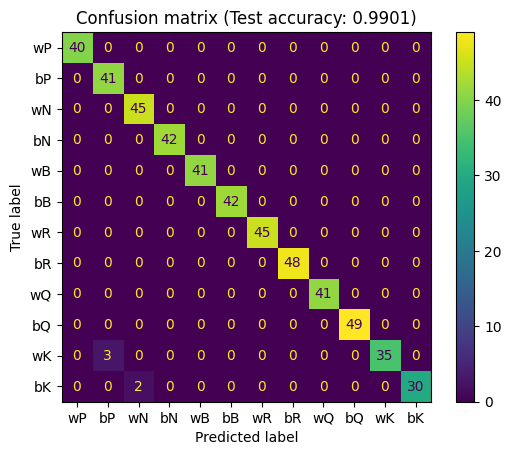

In [16]:
target, preds = info['target'].cpu(), info['preds'].cpu()
ConfusionMatrixDisplay.from_predictions(target, preds)
plt.title(f'Confusion matrix (Test accuracy: {test_accuracy:.4f})')
plt.gca().set_yticklabels(target_names)
plt.gca().set_xticklabels(target_names)
plt.show()

# Model test on real life screenshots

## Test screenshots resize

The first thing i need to do is resize the test screenshots to have dimensionality 640x640, so that the model will still be working on 80x80 single squares.

In [144]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Screenshot_Test/"

try:
  #Resized Screenshot test folder
  os.mkdir(f'{path}/Resized_Test/')
except FileExistsError:
    print("Folder already exists!")

for img_name in os.listdir(path):
  img_path = os.path.join(path,img_name)
  if not os.path.isdir(img_path):
    img = cv2.imread(img_path)
    new_dimensions = (640,640)
    resized_img = cv2.resize(img, new_dimensions, interpolation=cv2.INTER_AREA) #this type of interpolation tries to keep the quality when upscaling/downscaling
    resized_test_path = os.path.join(path,f"Resized_Test/{img_name}")
    cv2.imwrite(resized_test_path, resized_img) #overwrite the existing images with the resized ones

Mounted at /content/gdrive


## Single cells from screenshot

In [244]:
# return a matrix containing each cell in order (from 0_0 to 7_7)
def cells_from_screenshot(image_path):
    chessboard_row = []
    cont = 0
    image = cv2.imread(image_path)

    #Define the size of the squares
    square_size = 80
    parts = []

    for i in range(0, 640, square_size):
      for j in range(0, 640, square_size):
        square = image[i:i + square_size, j:j + square_size]
        parts.append(square)

    image_path = image_path.split("/")[-1]
    print(f"\nImage: {image_path}")
    fig = plt.figure(figsize=(8, 8))  # Adjust figure size
    grid = ImageGrid(fig, 111, nrows_ncols=(8, 8), axes_pad=.09)

    for ax, img in zip(grid, parts):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for proper display
        ax.axis('off')  # Turn off axis labels

    plt.show()
    return parts

In [245]:
drive.mount('/content/gdrive',force_remount=True)
path="/content/gdrive/MyDrive/Projects/Lichess_Screenshot_To_FEN/Screenshot_Test/Resized_Test/"

for img_name in os.listdir(path):
  chessboard = cells_from_screenshot(os.path.join(path,img_name))

Output hidden; open in https://colab.research.google.com to view.